# Housing Price Prediction Capstone Project - Feature Selection

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from boruta import BorutaPy
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
df = pd.read_csv("Data files\data_preprocessed.csv")

In [3]:
pd.set_option('display.max_rows', 500)

In [4]:
df.head()

,SalePrice,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,...,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_None,MiscFeature_Shed
0,208500,0.279857,-0.217666,0.888197,0.682376,-0.393202,-0.754347,1.344658,0.692021,1.167737,...,0,0,1,0,0,0,0,1,1,0
1,181500,0.760132,0.078136,-0.619443,1.339277,0.679639,0.478393,-0.786663,-0.376695,-0.781921,...,0,0,1,0,0,0,0,1,1,0
2,223500,0.375912,0.502548,0.626668,0.151058,-0.224084,-0.560023,1.374606,0.873321,1.167737,...,0,0,1,0,0,0,0,1,1,0
3,250000,0.888205,1.276779,2.072771,0.559207,0.370470,0.123145,1.841300,1.856159,1.167737,...,0,0,1,0,0,0,0,1,1,0
4,307000,0.600040,0.202631,0.811277,2.283573,1.800044,1.790077,-0.786663,0.653853,1.167737,...,0,0,1,0,0,0,0,1,1,0


In [5]:
df.columns

Index(['SalePrice', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       ...
       'PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y', 'Fence_GdPrv',
       'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw', 'Fence_None',
       'MiscFeature_None', 'MiscFeature_Shed'],
      dtype='object', length=138)

In [6]:
from sklearn.model_selection import train_test_split

X=df.drop(columns='SalePrice')
y=df.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [7]:
X_train.shape, X_test.shape

((795, 137), (342, 137))

In [8]:
scaler = StandardScaler()
scaler.fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

In [9]:
rng = np.random.RandomState(0)
bin_var = pd.Series(rng.randint(0, 1, X.shape[0]), name='rnd_bin')
num_var = pd.Series(np.arange(X.shape[0]), name='rnd_num')
X_with_rnd_feat = pd.concat((X, bin_var, num_var), axis=1)

## Basic Linear Model

In [10]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [11]:
lr = LinearRegression()
lr.fit(X_tr_scaled, y_train)

LinearRegression()

In [12]:
y_tr_pred = lr.predict(X_tr_scaled)
y_te_pred = lr.predict(X_te_scaled)

In [13]:
r2_score(y_test, y_te_pred), r2_score(y_train, y_tr_pred)

(-5.2650307219569725e+25, 0.9206463863892657)

### Non-scaled Data

In [14]:
y_tr_pred = lr.predict(X_train)
y_te_pred = lr.predict(X_test)

In [15]:
r2_score(y_test, y_te_pred), r2_score(y_train, y_tr_pred)

(-7.060952414197933e+25, -6.898800221007851e+25)

In [16]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(5.272420534174863e+17, 5.26061228898121e+17)

In [17]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(2.8504267705811347e+35, 2.8649921106467037e+35)

## Feature Selection

We will start by adding a random predictor variable to compare our other features against, anything that performs worse than these random values, will be removed from our model.

In [18]:
#creating random predictor variable
rng = np.random.RandomState(0)
bin_var = pd.Series(rng.randint(0, 1, X.shape[0]), name='rnd_bin')
num_var = pd.Series(np.arange(X.shape[0]), name='rnd_num')
X_with_rnd_feat = pd.concat((X, bin_var, num_var), axis=1)

In [19]:
#Re-split dataset with new random feature added
X_train, X_test, y_train, y_test = train_test_split(X_with_rnd_feat, y,
                                                    random_state=42)

### RidgeCV

In [23]:
model = RidgeCV()
model.fit(X_train, y_train)

print(f'model score on training data: {rcv.score(X_train, y_train)}')
print(f'model score on testing data: {rcv.score(X_test, y_test)}')

model score on training data: 0.9151950277677203
model score on testing data: 0.8698207944850297


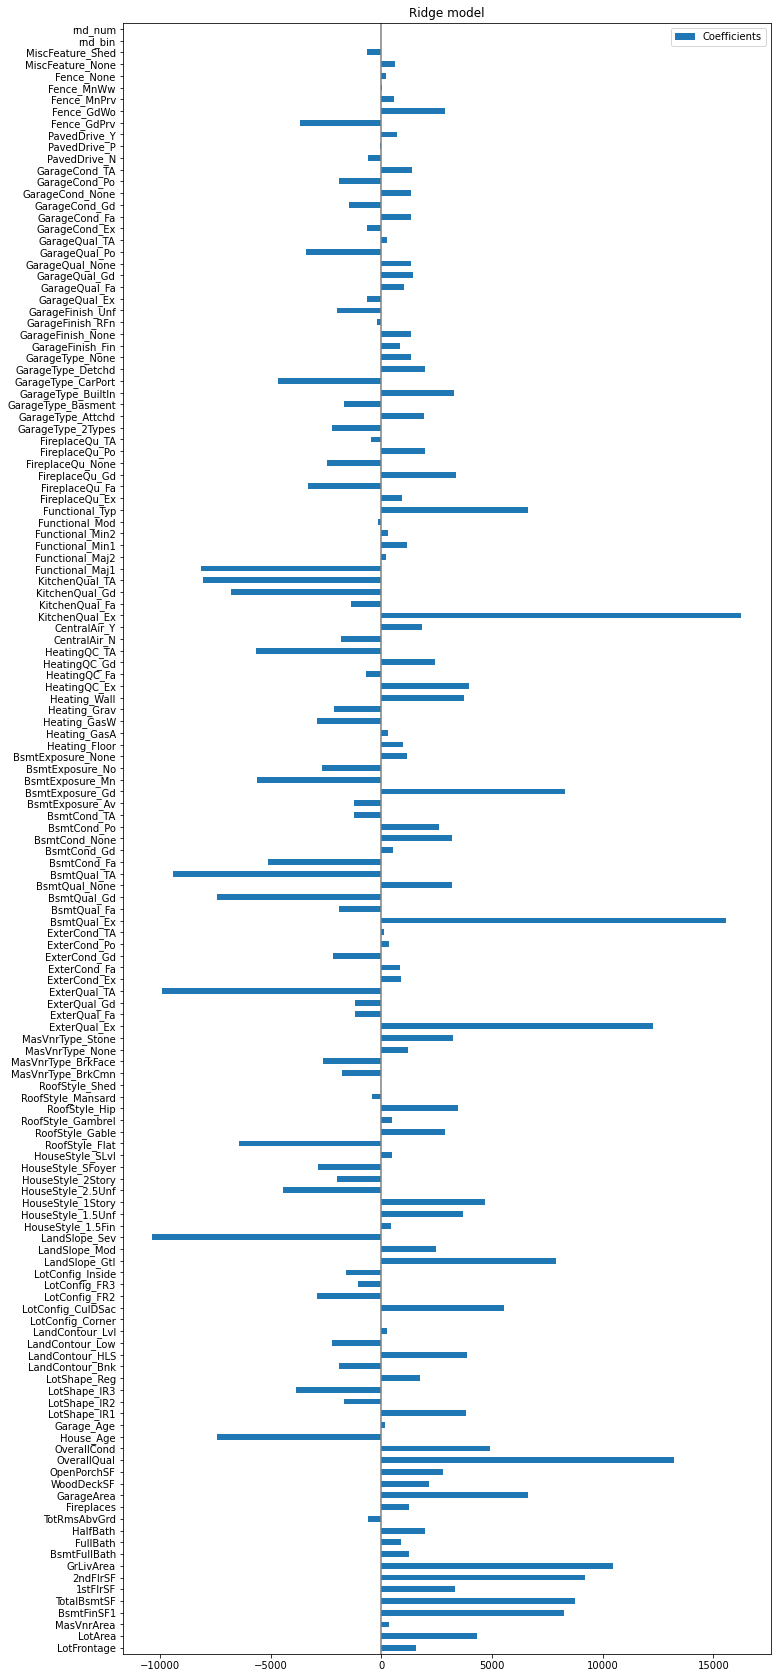

In [24]:
coefs = pd.DataFrame(
   model.coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(15,30))
plt.title('Ridge model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

### RidgeCV with StandardScaler

In [28]:
model = make_pipeline(StandardScaler(), RidgeCV())
model.fit(X_train, y_train)

print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')

model score on training data: 0.9219204942314903
model score on testing data: 0.8286317220327041


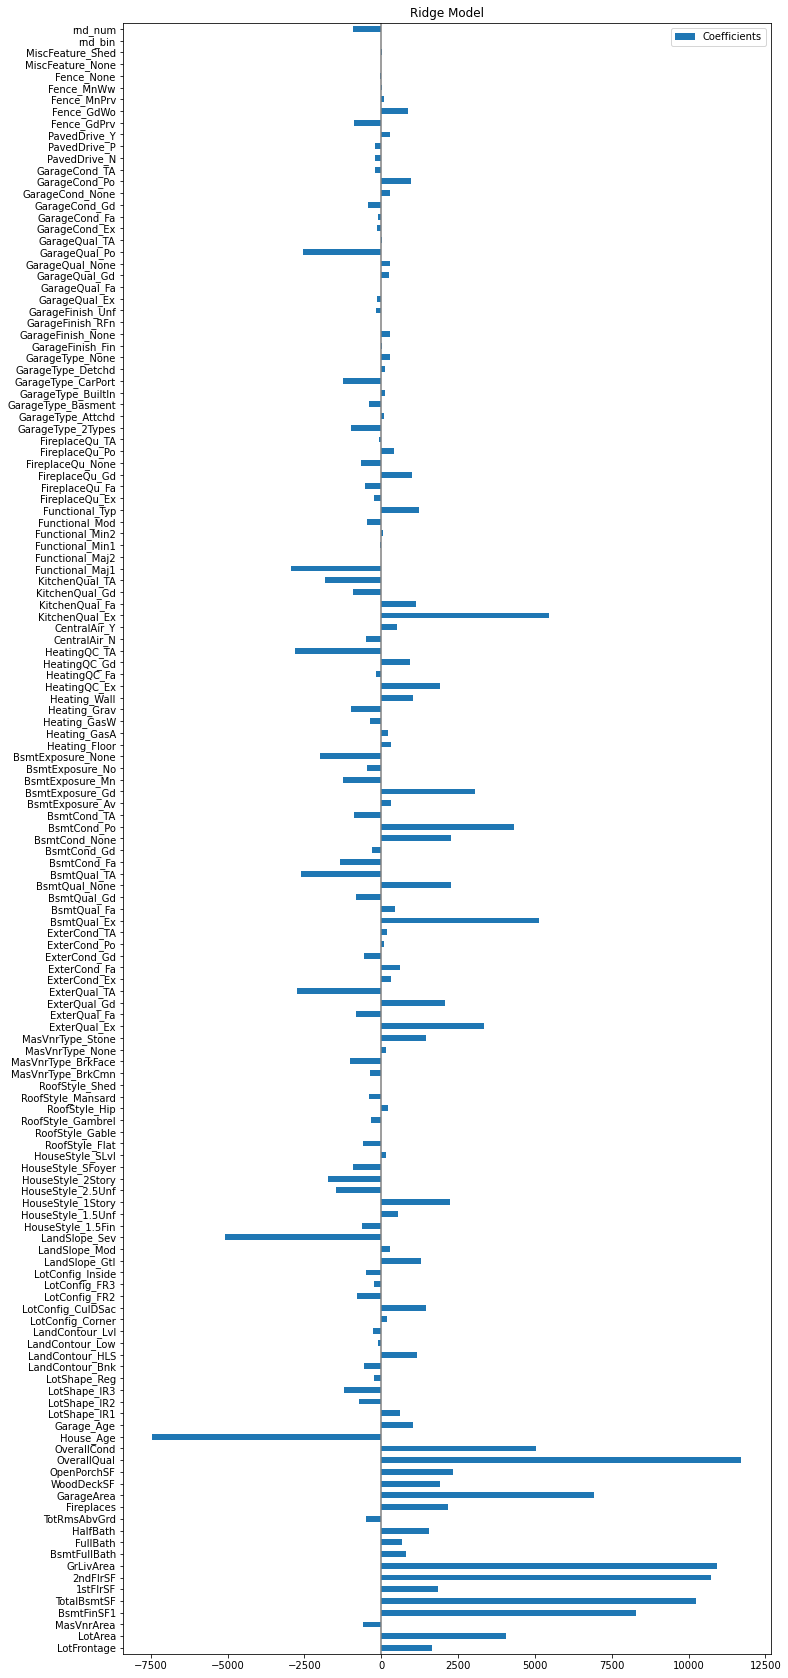

In [29]:
coefs = pd.DataFrame(
    model[1].coef_,
    columns=['Coefficients'], index=X_train.columns)

coefs.plot(kind='barh', figsize=(15,30))
plt.title('Ridge Model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

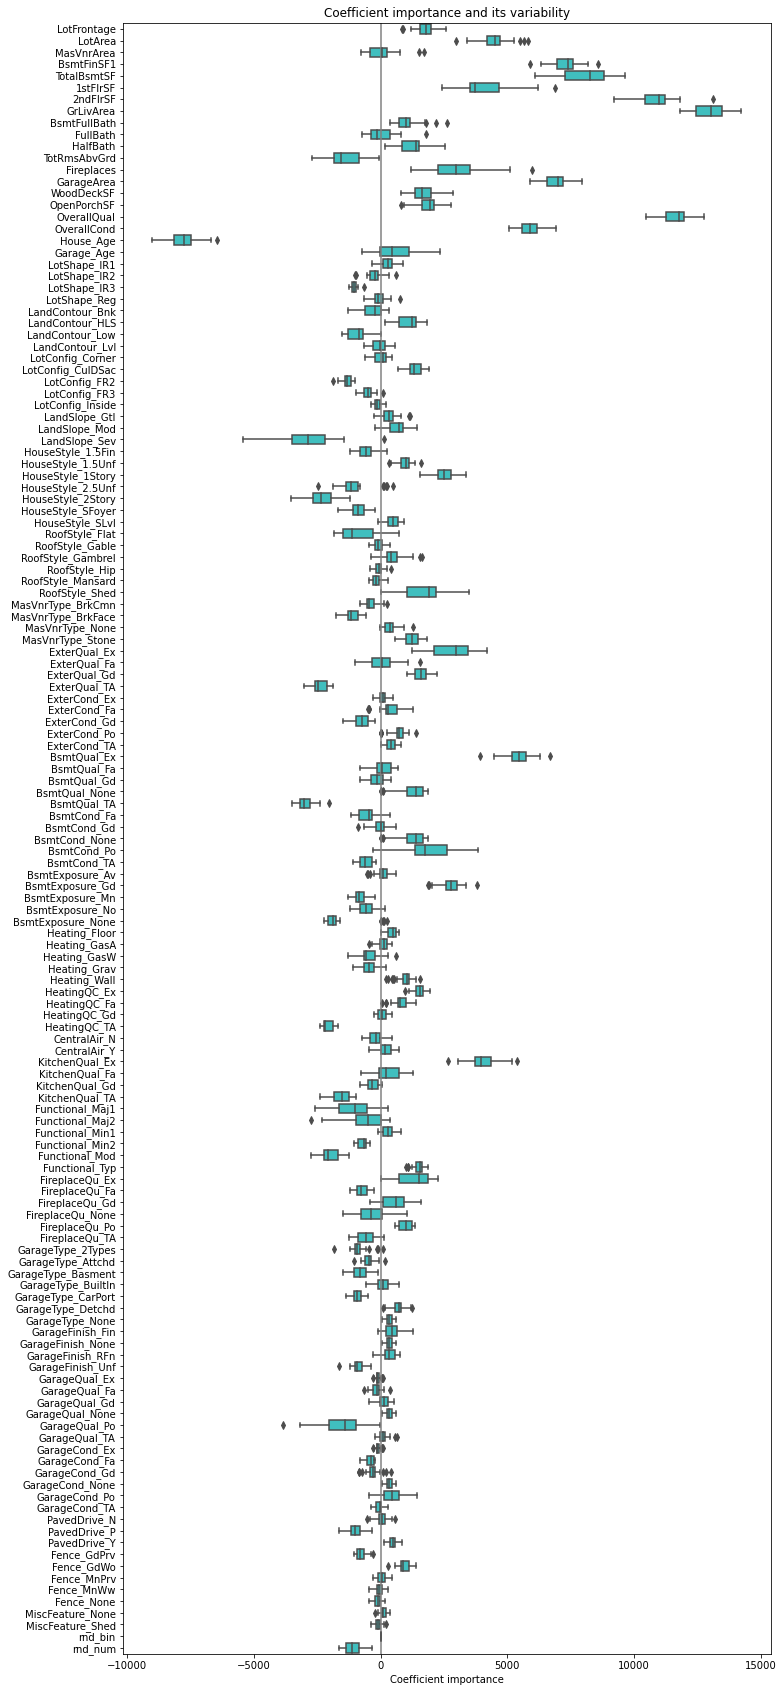

In [30]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
   model, X_with_rnd_feat, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
   return_estimator=True, n_jobs=2
)
coefs = pd.DataFrame(
   [model[1].coef_
    for model in cv_model['estimator']],
   columns=X_with_rnd_feat.columns
)
plt.figure(figsize=(15, 30))
sns.boxplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')
plt.subplots_adjust(left=.3)

In [31]:
print(np.mean(coefs).sort_values(ascending=False))

GrLivArea             13047.386067
OverallQual           11624.602499
2ndFlrSF              10876.504408
TotalBsmtSF            8003.676998
BsmtFinSF1             7341.234545
GarageArea             6927.661361
OverallCond            5913.357862
BsmtQual_Ex            5434.228617
LotArea                4489.909440
1stFlrSF               4104.084799
KitchenQual_Ex         4035.659299
Fireplaces             3120.455501
ExterQual_Ex           2882.012527
BsmtExposure_Gd        2772.841495
HouseStyle_1Story      2471.169167
OpenPorchSF            1884.639999
BsmtCond_Po            1847.464926
LotFrontage            1788.820073
WoodDeckSF             1691.666126
ExterQual_Gd           1613.268741
RoofStyle_Shed         1608.063310
HeatingQC_Ex           1538.297815
Functional_Typ         1498.320237
LotConfig_CulDSac      1361.388950
FireplaceQu_Ex         1336.228543
HalfBath               1304.896198
MasVnrType_Stone       1233.897396
BsmtQual_None          1194.357806
BsmtCond_None       

### Random Forest 

In [32]:
rfr1 = RandomForestRegressor()
rfr1.fit(X_train, y_train)

print(f'model score on training data: {rfr1.score(X_train, y_train)}')
print(f'model score on testing data: {rfr1.score(X_test, y_test)}')

model score on training data: 0.9830676957910044
model score on testing data: 0.8706985018207087


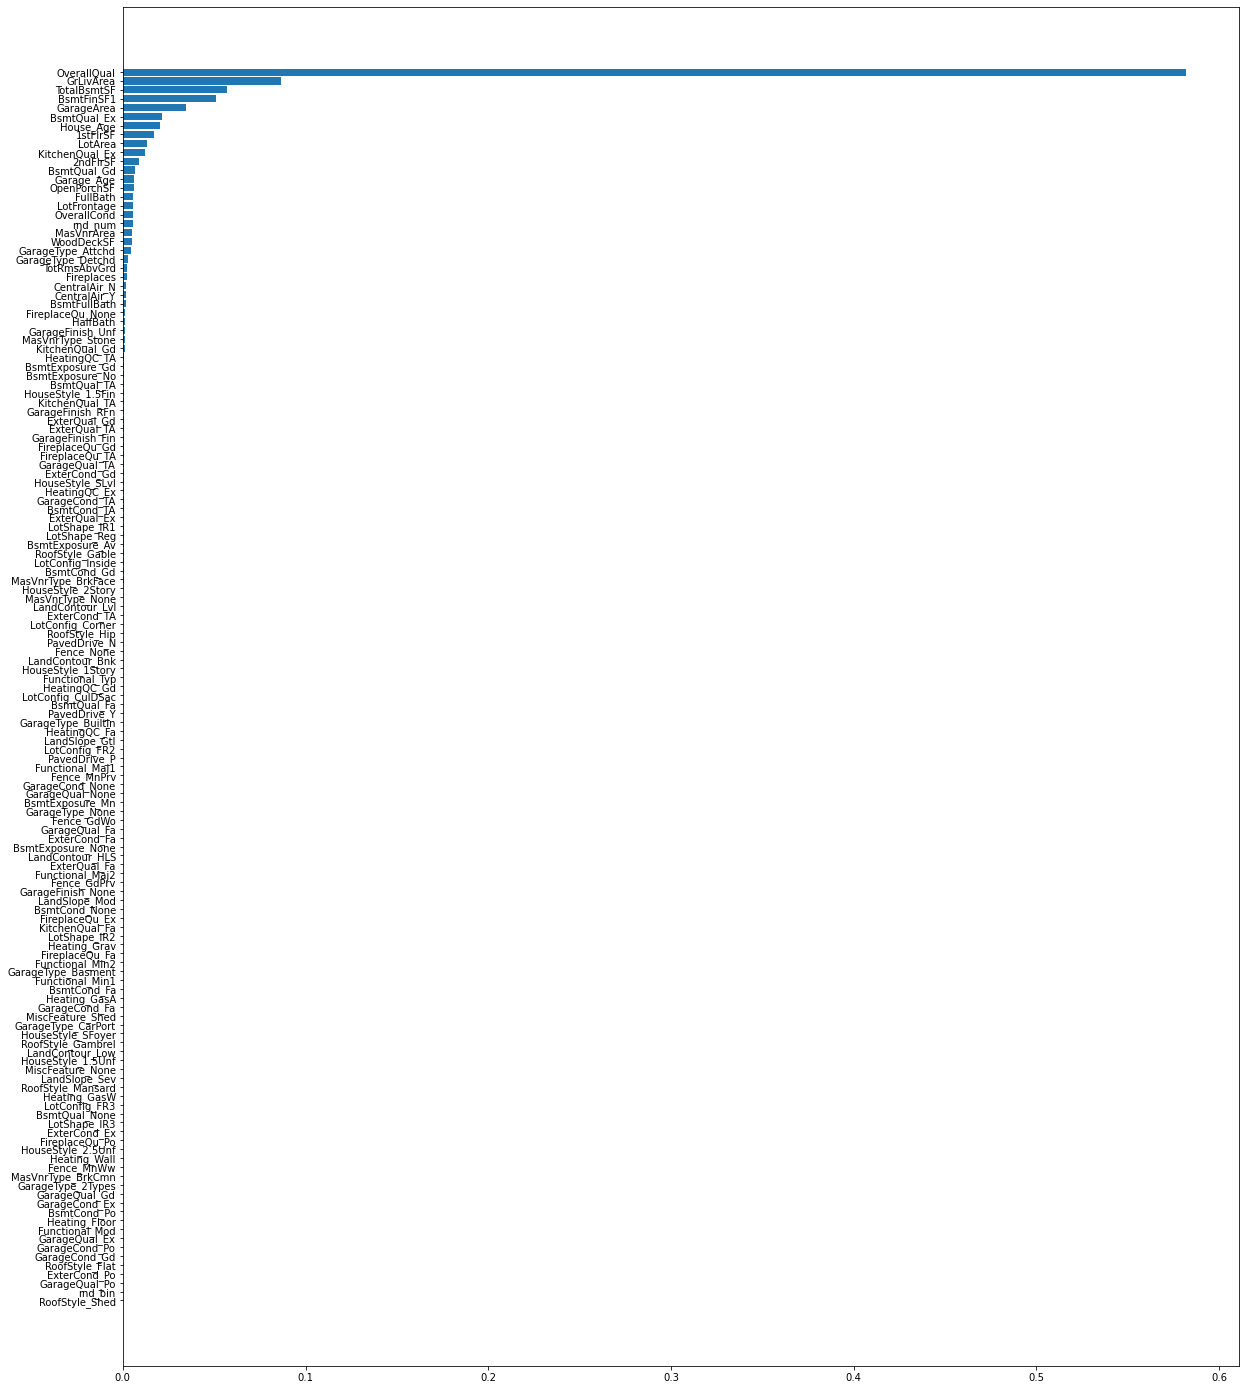

In [33]:
imps = rfr1.feature_importances_
feat_imps = imps
indices = np.argsort(feat_imps)

fix,ax = plt.subplots(figsize=(20,25))
ax.barh(range(len(feat_imps)), feat_imps[indices])
ax.set_yticks(range(len(feat_imps)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

In [34]:
pd.Series(rfr1.feature_importances_, index=X_train.columns).sort_values(ascending=False)

OverallQual           5.817482e-01
GrLivArea             8.644071e-02
TotalBsmtSF           5.727634e-02
BsmtFinSF1            5.117845e-02
GarageArea            3.444275e-02
BsmtQual_Ex           2.165546e-02
House_Age             2.027141e-02
1stFlrSF              1.706095e-02
LotArea               1.309738e-02
KitchenQual_Ex        1.231587e-02
2ndFlrSF              8.643084e-03
BsmtQual_Gd           6.750829e-03
Garage_Age            6.338348e-03
OpenPorchSF           6.133561e-03
FullBath              5.460055e-03
LotFrontage           5.399529e-03
OverallCond           5.398552e-03
rnd_num               5.354404e-03
MasVnrArea            5.032177e-03
WoodDeckSF            5.007192e-03
GarageType_Attchd     4.360433e-03
GarageType_Detchd     2.649464e-03
TotRmsAbvGrd          2.305653e-03
Fireplaces            2.139793e-03
CentralAir_N          1.935169e-03
CentralAir_Y          1.649279e-03
BsmtFullBath          1.524839e-03
FireplaceQu_None      1.221042e-03
HalfBath            

### RF with hyperparameter tuning

In [35]:
rfr2 = RandomForestRegressor(
         n_estimators=100,
         min_samples_leaf=1,
         n_jobs=-1,
         oob_score=True)
rfr2.fit(X_train, y_train)

print(f'model score on training data: {rfr2.score(X_train, y_train)}')
print(f'model score on testing data: {rfr2.score(X_test, y_test)}')

model score on training data: 0.9842736840718355
model score on testing data: 0.8698192024876439


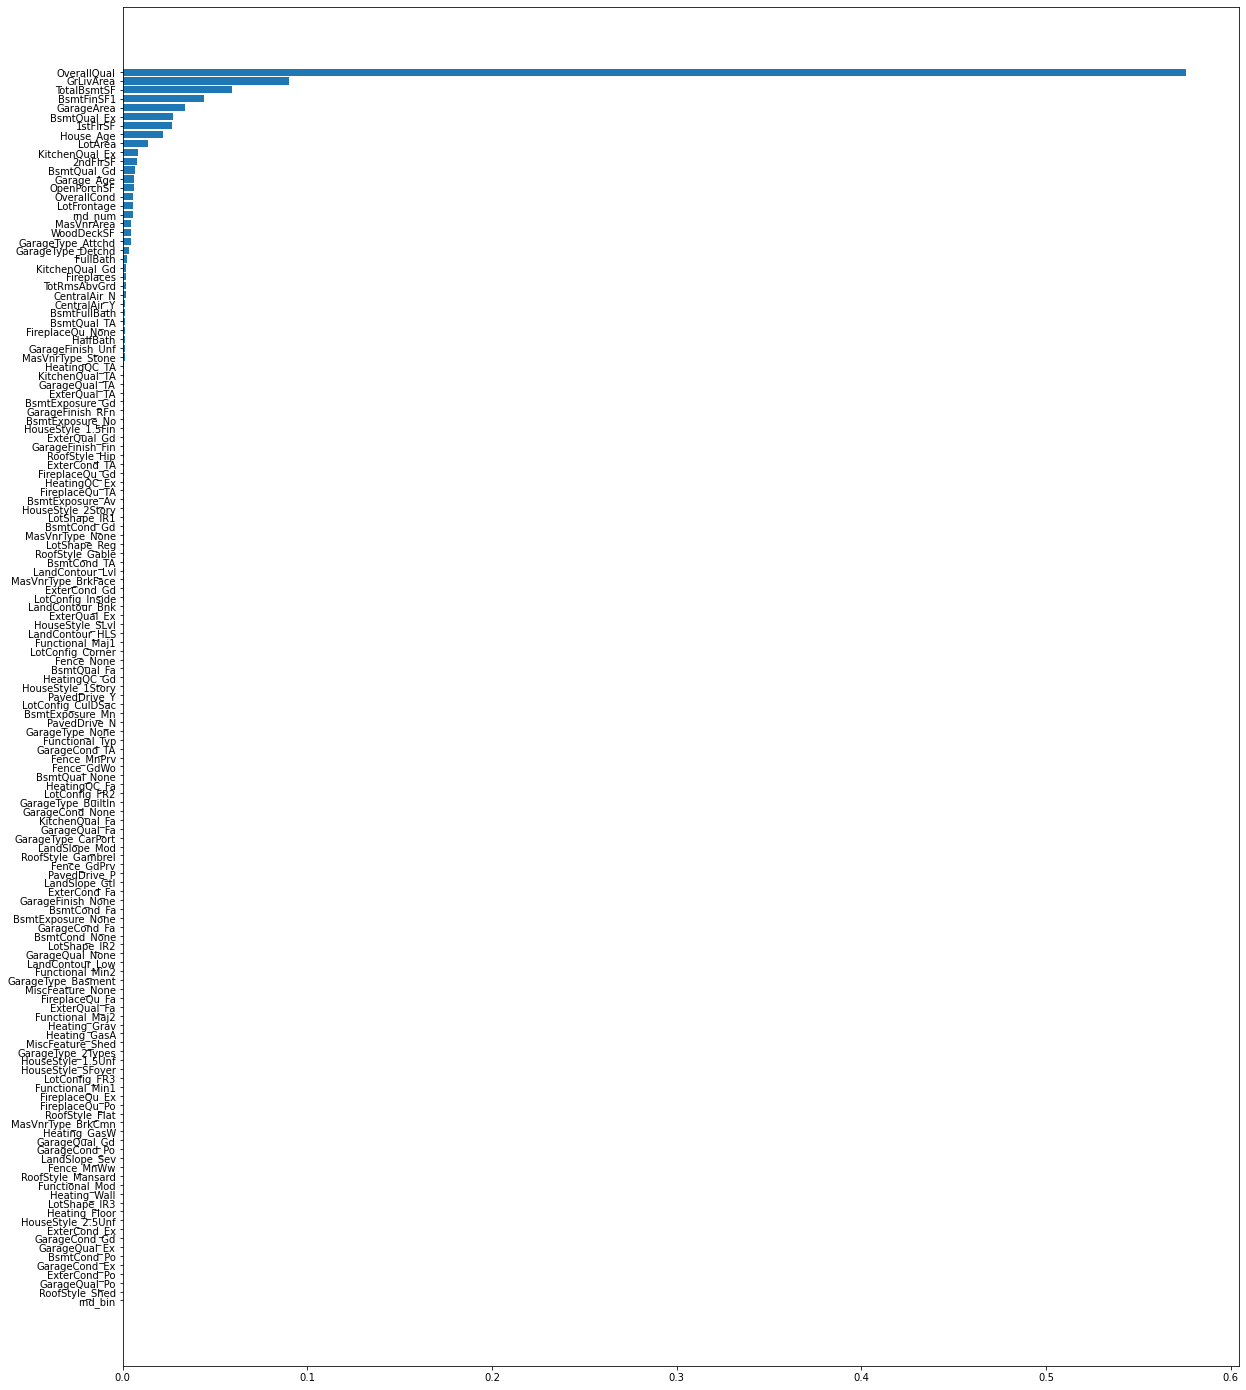

In [36]:
imps = rfr2.feature_importances_
feat_imps = imps
indices = np.argsort(feat_imps)

fix,ax = plt.subplots(figsize=(20,25))
ax.barh(range(len(feat_imps)), feat_imps[indices])
ax.set_yticks(range(len(feat_imps)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

In [37]:
feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
feat_imps

OverallQual           5.757232e-01
GrLivArea             9.026742e-02
TotalBsmtSF           5.904870e-02
BsmtFinSF1            4.399466e-02
GarageArea            3.388451e-02
BsmtQual_Ex           2.719882e-02
1stFlrSF              2.649417e-02
House_Age             2.196153e-02
LotArea               1.385774e-02
KitchenQual_Ex        8.259587e-03
2ndFlrSF              7.623239e-03
BsmtQual_Gd           6.553847e-03
Garage_Age            6.042103e-03
OpenPorchSF           5.836678e-03
OverallCond           5.668573e-03
LotFrontage           5.632920e-03
rnd_num               5.391434e-03
MasVnrArea            4.438917e-03
WoodDeckSF            4.396588e-03
GarageType_Attchd     4.309863e-03
GarageType_Detchd     3.508532e-03
FullBath              2.508035e-03
KitchenQual_Gd        1.989215e-03
Fireplaces            1.855440e-03
TotRmsAbvGrd          1.779523e-03
CentralAir_N          1.675559e-03
CentralAir_Y          1.375742e-03
BsmtFullBath          1.245186e-03
BsmtQual_TA         

These results look promising, as the square footage of the home should be one of, if not, the best predictor of home value. However, our random number feature we added appears #13 on this list, which means a vast majority of our other features are not very useful, or at least not in this permutation. 

### Feature Importance through Permutations with Random Forest

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from distutils.version import LooseVersion
if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
    # In sklearn version 0.24, forest module changed to be private.
    from sklearn.ensemble._forest import _generate_unsampled_indices
    from sklearn.ensemble import _forest as forest
else:
    # Before sklearn version 0.24, forest was public, supporting this.
    from sklearn.ensemble.forest import _generate_unsampled_indices
    from sklearn.ensemble import forest

from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from pandas.api.types import is_numeric_dtype
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FormatStrFormatter
from copy import copy
import warnings
import tempfile
from os import getpid, makedirs

C:\Users\nicho\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [39]:
def permutation_importances(rf, X_train, y_train, metric):
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)

In [40]:
def oob_regression_r2_score(rf, X_train, y_train):
    """
    Compute out-of-bag (OOB) R^2 for a scikit-learn random forest
    regressor. We learned the guts of scikit's RF from the BSD licensed
    code:
    https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/ensemble/forest.py#L702
    """
    X = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
    y = y_train.values if isinstance(y_train, pd.Series) else y_train

    n_samples = len(X)
    predictions = np.zeros(n_samples)
    n_predictions = np.zeros(n_samples)
    for tree in rf.estimators_:
        unsampled_indices = _get_unsampled_indices(tree, n_samples)
        tree_preds = tree.predict(X[unsampled_indices, :])
        predictions[unsampled_indices] += tree_preds
        n_predictions[unsampled_indices] += 1

    if (n_predictions == 0).any():
        warnings.warn("Too few trees; some variables do not have OOB scores.")
        n_predictions[n_predictions == 0] = 1

    predictions /= n_predictions

    oob_score = r2_score(y, predictions)
    return oob_score

In [41]:
def _get_unsampled_indices(tree, n_samples):
    """
    An interface to get unsampled indices regardless of sklearn version.
    """
    if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
        # Version 0.24 moved forest package name
        from sklearn.ensemble._forest import _get_n_samples_bootstrap
        n_samples_bootstrap = _get_n_samples_bootstrap(n_samples, n_samples)
        return _generate_unsampled_indices(tree.random_state, n_samples, n_samples_bootstrap)
    elif LooseVersion(sklearn.__version__) >= LooseVersion("0.22"):
        # Version 0.22 or newer uses 3 arguments.
        from sklearn.ensemble.forest import _get_n_samples_bootstrap
        n_samples_bootstrap = _get_n_samples_bootstrap(n_samples, n_samples)
        return _generate_unsampled_indices(tree.random_state, n_samples, n_samples_bootstrap)
    else:
        # Version 0.21 or older uses only two arguments.
        return _generate_unsampled_indices(tree.random_state, n_samples)

In [42]:
RF = RandomForestRegressor()
RF.fit(X_train, y_train)
imp = permutation_importances(RF, X_train, y_train, oob_regression_r2_score)

<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = np.random.permutation(X_train[col])
<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = save
<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = save
<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = np.random.permutation(X_train[col])
<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = np.random.permutation(X_train[col])
<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = save
<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = save
<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = np.random.permutation(X_train[col])
<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = save
<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = np.random.permutation(X_train[col])
<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = save
<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = np.random.permutation(X_train[col])
<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = save
<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = np.random.permutation(X_train[col])
<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = np.random.permutation(X_train[col])
<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = save
<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = save
<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = np.random.permutation(X_train[col])
<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = np.random.permutation(X_train[col])
<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = save
<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

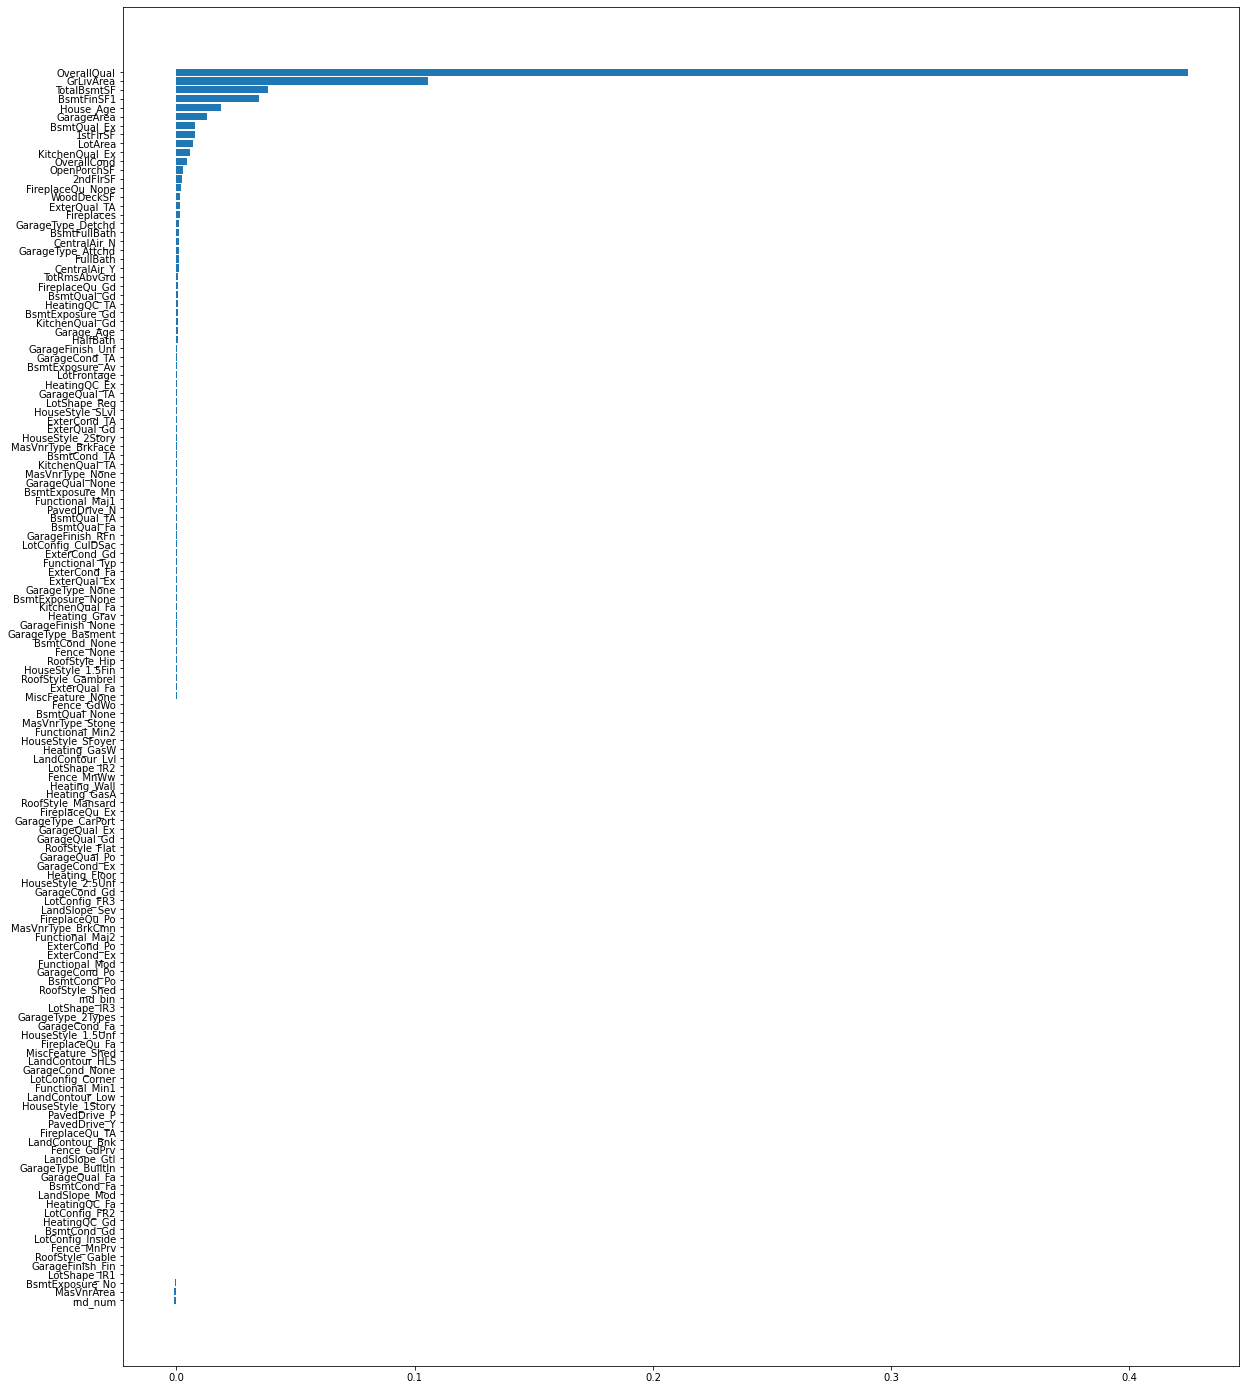

In [43]:
feat_imps = imp
indices = np.argsort(feat_imps)

fix,ax = plt.subplots(figsize=(20,25))
ax.barh(range(len(feat_imps)), feat_imps[indices])
ax.set_yticks(range(len(feat_imps)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

In [44]:
pd.Series(imp, index=X_train.columns).sort_values(ascending=False)

OverallQual           4.246095e-01
GrLivArea             1.056250e-01
TotalBsmtSF           3.823270e-02
BsmtFinSF1            3.450261e-02
House_Age             1.881977e-02
GarageArea            1.283470e-02
BsmtQual_Ex           7.745625e-03
1stFlrSF              7.601964e-03
LotArea               6.760659e-03
KitchenQual_Ex        5.498418e-03
OverallCond           4.539275e-03
OpenPorchSF           2.693510e-03
2ndFlrSF              2.400849e-03
FireplaceQu_None      1.796538e-03
WoodDeckSF            1.459809e-03
ExterQual_TA          1.454545e-03
Fireplaces            1.291513e-03
GarageType_Detchd     1.194884e-03
BsmtFullBath          1.081539e-03
CentralAir_N          1.066617e-03
GarageType_Attchd     1.050242e-03
FullBath              9.320383e-04
CentralAir_Y          8.538398e-04
TotRmsAbvGrd          8.487457e-04
FireplaceQu_Gd        8.085365e-04
BsmtQual_Gd           7.136441e-04
HeatingQC_TA          6.888319e-04
BsmtExposure_Gd       6.594361e-04
KitchenQual_Gd      

In [45]:
RF.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Hyperparameter tuning

#### RandomizedSearchCV

In [46]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [47]:
# Use the random grid to search for best hyperparameters
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.5min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [48]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [49]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


Model Performance
Average Error: 17932.8516 degrees.
Accuracy = 88.92%.
Model Performance
Average Error: 16150.4215 degrees.
Accuracy = 90.10%.
Improvement of 1.32%.


### Permutation again with new parameters

In [50]:
RF = RandomForestRegressor(n_estimators= 400,
 min_samples_split= 2,
 min_samples_leaf= 1,
 max_features= 'sqrt',
 max_depth= None,
 bootstrap= False)
RF.fit(X_train, y_train)
imp_new_params = permutation_importances(RF, X_train, y_train, oob_regression_r2_score)

<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = np.random.permutation(X_train[col])
<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = save
<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = save
<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = np.random.permutation(X_train[col])
<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = save
<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = np.random.permutation(X_train[col])
<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = save
<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = np.random.permutation(X_train[col])
<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = save
<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = np.random.permutation(X_train[col])
<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = save
<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = np.random.permutation(X_train[col])
<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = save
<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = np.random.permutation(X_train[col])
<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = save
<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = np.random.permutation(X_train[col])
<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = np.random.permutation(X_train[col])
<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = save
<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = save
<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = np.random.permutation(X_train[col])
<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = save
<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = np.random.permutation(X_train[col])
<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = save
<ipython-input-39-02a282ac55b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = np.random.permutation(X_train[col])
<ipython-input-39-02a282ac55b1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

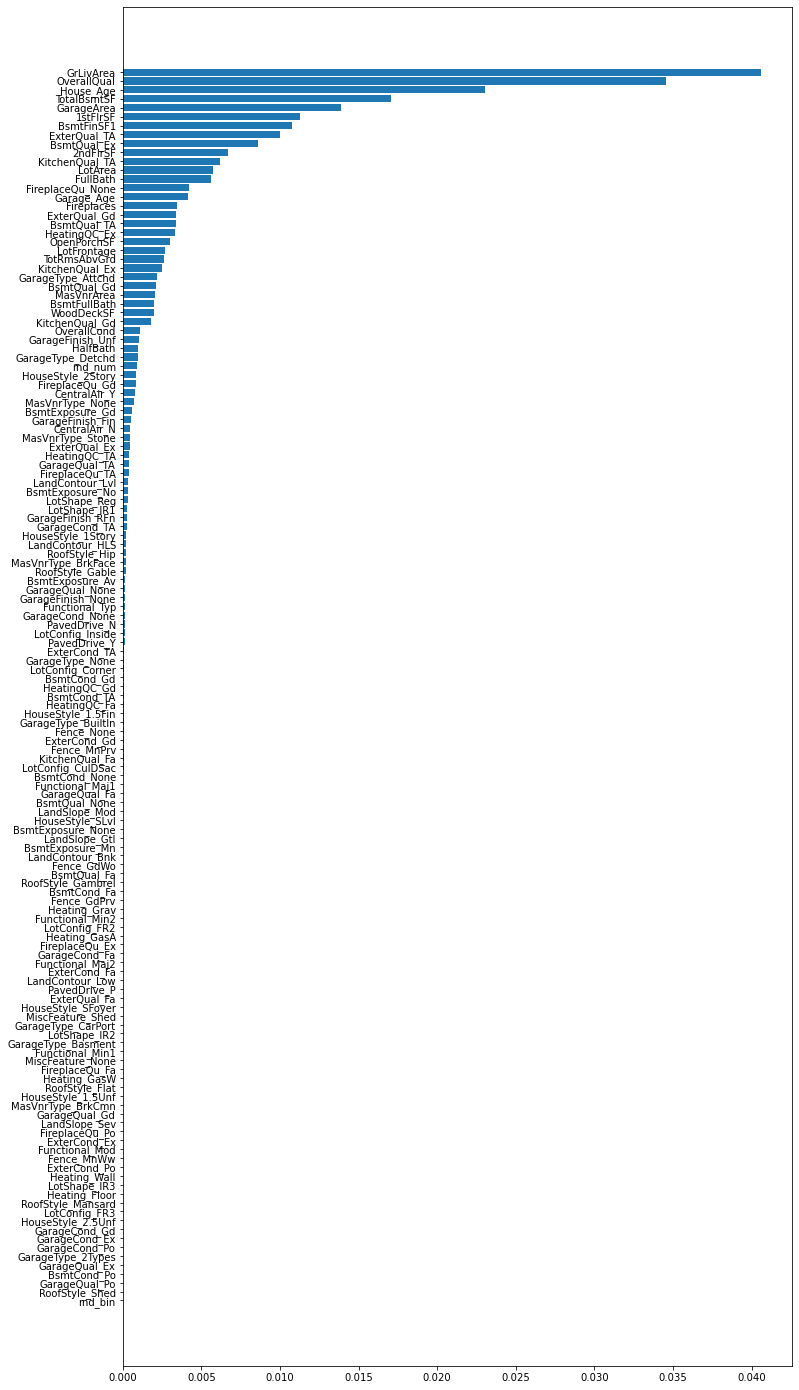

In [56]:
feat_imps = imp_new_params
indices = np.argsort(feat_imps)

fix,ax = plt.subplots(figsize=(12,25))
ax.barh(range(len(feat_imps)), feat_imps[indices])
ax.set_yticks(range(len(feat_imps)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

In [52]:
pd.Series(imp_new_params, index=X_train.columns).sort_values(ascending=False)

GrLivArea             4.057489e-02
OverallQual           3.455112e-02
House_Age             2.307156e-02
TotalBsmtSF           1.708470e-02
GarageArea            1.387192e-02
1stFlrSF              1.125856e-02
BsmtFinSF1            1.078686e-02
ExterQual_TA          9.970891e-03
BsmtQual_Ex           8.582411e-03
2ndFlrSF              6.720999e-03
KitchenQual_TA        6.165572e-03
LotArea               5.727806e-03
FullBath              5.638520e-03
FireplaceQu_None      4.195600e-03
Garage_Age            4.137804e-03
Fireplaces            3.456723e-03
ExterQual_Gd          3.387122e-03
BsmtQual_TA           3.365892e-03
HeatingQC_Ex          3.288805e-03
OpenPorchSF           2.985445e-03
LotFrontage           2.673035e-03
TotRmsAbvGrd          2.607243e-03
KitchenQual_Ex        2.495457e-03
GarageType_Attchd     2.182350e-03
BsmtQual_Gd           2.102167e-03
MasVnrArea            2.018845e-03
BsmtFullBath          1.989869e-03
WoodDeckSF            1.958907e-03
KitchenQual_Gd      

Our final features for our model will be: GrLivArea, TotalBsmtSF, GarageArea, 1stFlrSF, 2ndFlrSF, BsmtFinSF1, OpenPorchSF, LotArea, LotFrontage, WoodDeckSF

In [53]:
selected_features = ['House_Age ','GrLivArea','OverallQual', 'TotalBsmtSF', 'GarageArea', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'LotArea','FullBath']